In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pastry-prediction/sample_submission.csv
/kaggle/input/pastry-prediction/train.csv
/kaggle/input/pastry-prediction/test.csv


In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from io import StringIO
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import openpyxl
import plotly.graph_objects as go
from matplotlib.sankey import Sankey
from xgboost import XGBRegressor

In [3]:
pastry_train = "/kaggle/input/pastry-prediction/train.csv"
pastry_test = "/kaggle/input/pastry-prediction/test.csv"

# Outline 

Objective: Develop models that enable better pastry production planning. By accurately predicting daily and seasonal variations in sales, bakeries can produce just the right amount.

How: Model building. 

Evaluation: Solutions will be evaluated using Mean Squared Error (MSE) between predicted sales per store and the obsered target. 

Prediction Target: sales column in train. 

# Exploratory Data Analysis 
Understand the datasets

In [4]:
pastry_train_df = pd.read_csv(pastry_train)

In [5]:
pastry_test_df = pd.read_csv(pastry_test)

**Numeric and Categorical columns in Train**

In [6]:
numeric_cols_train = pastry_train_df.select_dtypes(include=['number']).columns
print("Numeric Columns in Train:", numeric_cols_train)

Numeric Columns in Train: Index(['temperature_max', 'temperature_min', 'temperature_mean',
       'sunshine_sum', 'precipitation_sum', 'sales', 'unsold', 'ordered'],
      dtype='object')


In [7]:
categorical_cols_train = pastry_train_df.select_dtypes(include=['object']).columns
print("Categorical Columns in Train:", categorical_cols_train)

Categorical Columns in Train: Index(['date', 'store', 'is_state_holiday', 'is_school_holiday',
       'is_special_day'],
      dtype='object')


**Numeric and Categorical columns in Test**

In [8]:
numeric_cols_test = pastry_test_df.select_dtypes(include=['number']).columns
print("Numeric Columns in Test:", numeric_cols_test)

Numeric Columns in Test: Index(['row_id', 'temperature_max', 'temperature_min', 'temperature_mean',
       'sunshine_sum', 'precipitation_sum'],
      dtype='object')


In [9]:
categorical_cols_test = pastry_test_df.select_dtypes(include=['object']).columns
print("Categorical Columns in Test:", categorical_cols_test)

Categorical Columns in Test: Index(['date', 'store', 'is_state_holiday', 'is_school_holiday',
       'is_special_day'],
      dtype='object')


In [10]:
# Convert all categorical columns to numeric columns in both datasets
for df in [pastry_train_df, pastry_test_df]:
    df['date'] = pd.to_datetime(df['date'])  # Convert to datetime
    df['store_num'] = df['store'].astype('category').cat.codes
    df['is_state_holiday_num'] = df['is_state_holiday'].astype('category').cat.codes
    df['is_school_holiday_num'] = df['is_school_holiday'].astype('category').cat.codes
    df['is_special_day_num'] = df['is_special_day'].astype('category').cat.codes

In [11]:
print (pastry_train_df.min())

date                     2021-08-02 00:00:00
store                                store_0
is_state_holiday                   day_after
is_school_holiday                 normal_day
is_special_day                    day_before
temperature_max                         -4.4
temperature_min                         -8.1
temperature_mean                   -5.654545
sunshine_sum                               0
precipitation_sum                        0.0
sales                              -1.656999
unsold                             -1.289811
ordered                            -1.715776
store_num                                  0
is_state_holiday_num                       0
is_school_holiday_num                      0
is_special_day_num                         0
dtype: object


In [12]:
print (pastry_test_df.min())

row_id                                     0
date                     2023-12-01 00:00:00
store                                store_0
is_state_holiday                   day_after
is_school_holiday                  day_after
is_special_day                    normal_day
temperature_max                         -4.5
temperature_min                         -8.8
temperature_mean                   -6.545455
sunshine_sum                               0
precipitation_sum                        0.0
store_num                                  0
is_state_holiday_num                       0
is_school_holiday_num                      0
is_special_day_num                         0
dtype: object


In [13]:
print (pastry_train_df.max())

date                     2023-11-30 00:00:00
store                                store_8
is_state_holiday               state_holiday
is_school_holiday             school_holiday
is_special_day                   special_day
temperature_max                         37.7
temperature_min                         30.2
temperature_mean                   35.172727
sunshine_sum                             551
precipitation_sum                       32.2
sales                               7.539953
unsold                              7.472362
ordered                             7.869175
store_num                                  8
is_state_holiday_num                       3
is_school_holiday_num                      1
is_special_day_num                         2
dtype: object


In [14]:
print (pastry_test_df.max())

row_id                                  1574
date                     2024-05-31 00:00:00
store                                store_8
is_state_holiday               state_holiday
is_school_holiday             school_holiday
is_special_day                   special_day
temperature_max                         28.5
temperature_min                         21.0
temperature_mean                        24.8
sunshine_sum                             529
precipitation_sum                       27.9
store_num                                  8
is_state_holiday_num                       2
is_school_holiday_num                      3
is_special_day_num                         1
dtype: object


Max Date in pastry_train is 30th of November 2023 and Min Date in pastry_train is 2nd of August 2021

Max Date in pastry_test is 31st May 2025 and Min Date in pastry_test is 1st December 2023

In [15]:
# Finding the mode of temperature columns in sales_train_df
train_temp_mode = pastry_train_df[['temperature_max', 'temperature_min', 'temperature_mean']].mode().iloc[0]

# Finding the mode of temperature columns in sales_test_df
test_temp_mode = pastry_test_df[['temperature_max', 'temperature_min', 'temperature_mean']].mode().iloc[0]

# Display the modes
print("Mode of temperature columns in pastry_train_df:\n", train_temp_mode)
print("\nMode of temperature columns in pastry_test_df:\n", test_temp_mode)

Mode of temperature columns in pastry_train_df:
 temperature_max     21.800000
temperature_min      6.500000
temperature_mean    17.290909
Name: 0, dtype: float64

Mode of temperature columns in pastry_test_df:
 temperature_max     7.900000
temperature_min     5.100000
temperature_mean    8.354545
Name: 0, dtype: float64


Most frequent temperature, under pastry_train_df, in:
1. temperature_max = 21.8
2. temperature_min = 6.5
3. temperature_mean = 17.29

Most frequent temperature, under pastry_test_df, in:
1. temperature_max = 7.9
2. temperature_min = 5.1
3. temperature_mean = 8.355 (2.dp)

In [16]:
print(pastry_train_df["store"].value_counts())

store
store_5    847
store_8    847
store_7    847
store_4    847
store_1    847
store_6    331
store_0    273
store_3    242
store_2     61
Name: count, dtype: int64


In [17]:
print(pastry_test_df["store"].value_counts())

store
store_3    182
store_5    182
store_1    182
store_4    182
store_7    182
store_8    182
store_6    181
store_0    181
store_2    121
Name: count, dtype: int64


Store column in both train and test datasets have different value counts. As seen above. 
Therefore, no features for store column due to the incosistent logic between the two datasets. 

In [18]:
# print (pastry_test_df["is_special_day"].tolist())
# print (pastry_test_df["is_school_holiday"].tolist())
# print (pastry_test_df["is_state_holiday"].tolist())


* If there is no state holiday, it is a normal day.
* If there is state holiday, it is state holiday.
* If there is no school holiday, it is normal day.
* If there is school holiday, it is school holiday
* If there is no special holiday, it is normal day
* If there is special holiday, it is special day

Same logic for train


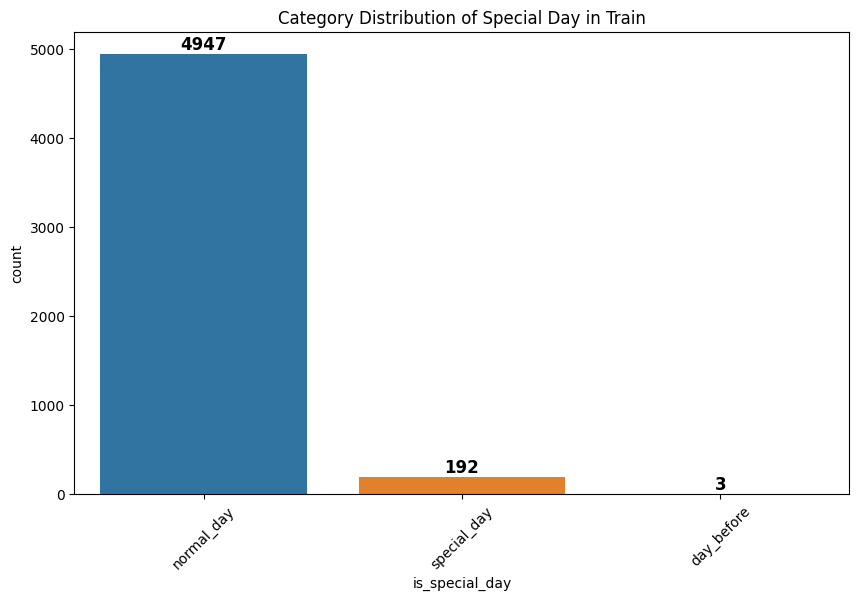

In [19]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.countplot(x=pastry_train_df["is_special_day"])

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Category Distribution of Special Day in Train")
plt.show()

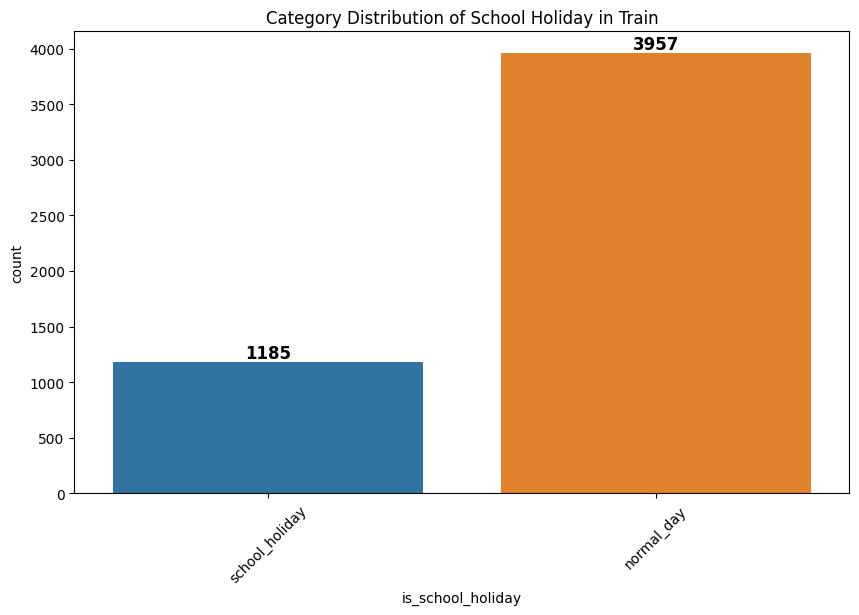

In [20]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.countplot(x=pastry_train_df["is_school_holiday"])

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Category Distribution of School Holiday in Train")
plt.show()

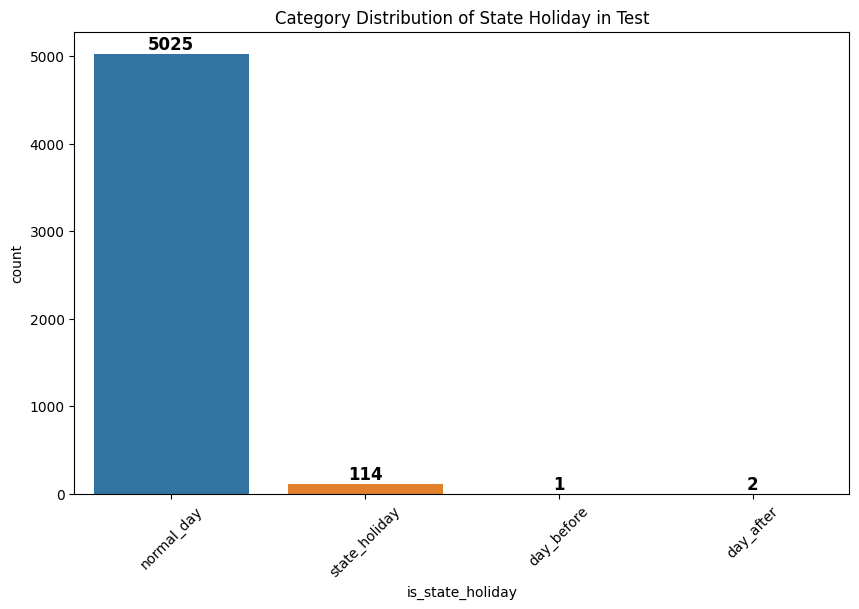

In [21]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.countplot(x=pastry_train_df["is_state_holiday"])

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Category Distribution of State Holiday in Test")
plt.show()

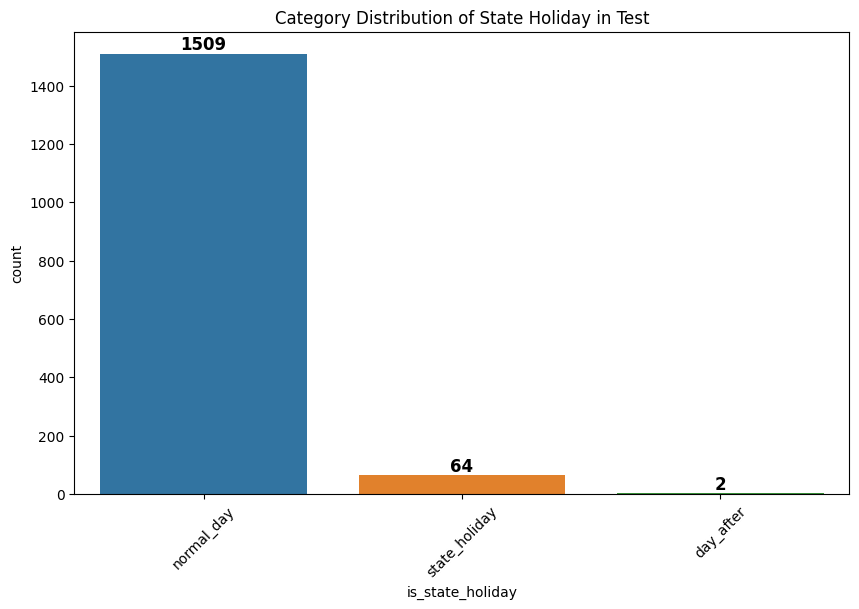

In [22]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.countplot(x=pastry_test_df["is_state_holiday"])

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Category Distribution of State Holiday in Test")
plt.show()

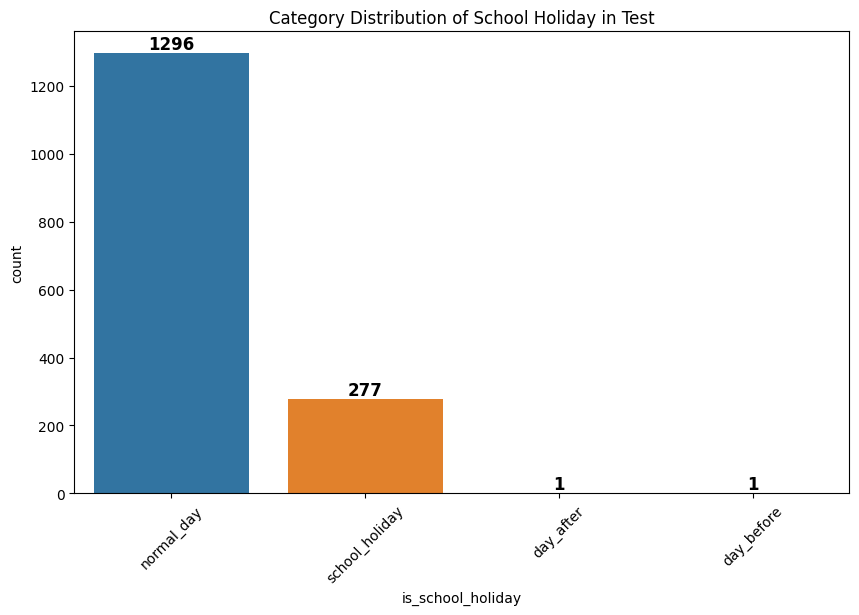

In [23]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.countplot(x=pastry_test_df["is_school_holiday"])

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Category Distribution of School Holiday in Test")
plt.show()

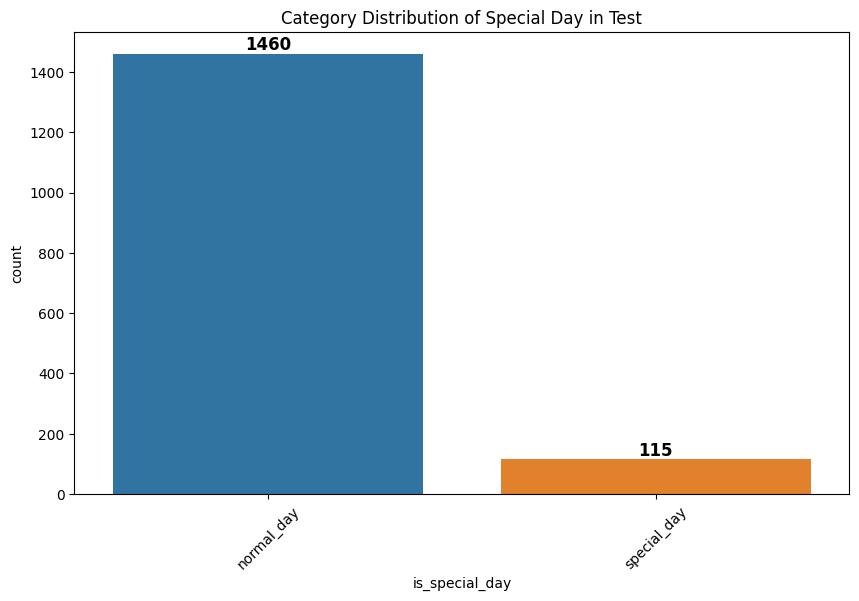

In [24]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.countplot(x=pastry_test_df["is_special_day"])

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Category Distribution of Special Day in Test")
plt.show()

Across train and test datasets, normal day has the highest frequency count. Therefore, on regular days, it appears that sales order could be high on those days.

In [25]:
print (pastry_test_df['precipitation_sum'].value_counts())

precipitation_sum
0.0    955
0.1     77
0.2     39
0.3     31
0.4     29
      ... 
5.8      1
3.6      1
7.2      1
9.5      1
7.6      1
Name: count, Length: 69, dtype: int64


In [26]:
print (pastry_train_df['precipitation_sum'].value_counts())

precipitation_sum
0.0     3383
0.1      207
0.2      127
0.3      102
0.4       81
        ... 
8.7        3
10.8       2
6.6        1
7.5        1
9.5        1
Name: count, Length: 93, dtype: int64


In [27]:
# Check the correlation between sunshine and sales in Train
discount_precipitation_corr = pastry_train_df[['precipitation_sum', 'sales']].corr()
print(discount_precipitation_corr)

                   precipitation_sum     sales
precipitation_sum           1.000000 -0.034883
sales                      -0.034883  1.000000


Consisten distribution (albeit with some differences) in percipitation_sum in both data sets. Negative weak corellation between sales and precipitation.

In [28]:
print (pastry_train_df['sunshine_sum'].value_counts())

sunshine_sum
0      924
1       92
3       45
10      42
2       39
      ... 
370      1
151      1
125      1
192      1
120      1
Name: count, Length: 431, dtype: int64


In [29]:
print (pastry_test_df['sunshine_sum'].value_counts())

sunshine_sum
0      418
1       24
6       22
3       18
76      14
      ... 
504      3
195      3
381      3
201      3
299      3
Name: count, Length: 205, dtype: int64


In [30]:
# Check the correlation between sunshine and sales in Train
discount_sunshine_corr = pastry_train_df[['sunshine_sum', 'sales']].corr()
print(discount_sunshine_corr)

              sunshine_sum     sales
sunshine_sum      1.000000 -0.101431
sales            -0.101431  1.000000


In [31]:
# Check the correlation between store and sales in Train
store_sales_corr_train = pastry_train_df[['store_num', 'sales']].corr()
print(store_sales_corr_train)

           store_num     sales
store_num   1.000000  0.401847
sales       0.401847  1.000000


In [32]:
# Check the correlation between state holiday and sales in Train
state_holiday_corr_train = pastry_train_df[['is_state_holiday_num', 'sales']].corr()
print(state_holiday_corr_train)

                      is_state_holiday_num     sales
is_state_holiday_num              1.000000  0.066896
sales                             0.066896  1.000000


In [33]:
# Check the correlation between school holiday and sales in Train
school_holiday_corr_train = pastry_train_df[['is_school_holiday_num', 'sales']].corr()
print(school_holiday_corr_train)

                       is_school_holiday_num     sales
is_school_holiday_num               1.000000 -0.044873
sales                              -0.044873  1.000000


In [34]:
# Check the correlation between special day and sales in Train
special_day_corr_train = pastry_train_df[['is_special_day_num', 'sales']].corr()
print(special_day_corr_train)

                    is_special_day_num     sales
is_special_day_num            1.000000  0.100762
sales                         0.100762  1.000000


In [35]:
# Check the correlation between special day and precipitation in Train
precipitation_corr_train = pastry_train_df[['is_special_day_num', 'precipitation_sum']].corr()
print(precipitation_corr_train)

                    is_special_day_num  precipitation_sum
is_special_day_num            1.000000           0.007732
precipitation_sum             0.007732           1.000000


In [36]:
# Check the correlation between special day and sunshine in Train
sunshine_corr_train = pastry_train_df[['is_special_day_num', 'sunshine_sum']].corr()
print(sunshine_corr_train)

                    is_special_day_num  sunshine_sum
is_special_day_num            1.000000      0.011273
sunshine_sum                  0.011273      1.000000


Consistent distriubtion (albeit with some differences) in sunshine_sum in both datasets. Negative weak correlation between sales and sunshine_sum (stronger than precipitation_sum, but still weak). 

## Conclusion from Exploratory Data Analysis
* **Precipitation and Sunshine have a weak negative relationship with sales**. Therefore, precipitation and sunshine does impact sales but not to a huge degree.
* On days that are normal days, sales could be high, but it is not possible to ascertain it.
* Temperature could play an effect, but we need to choose the appropriate temperature columns in each dataset. Going with the mean temperature is suitable because it is the average temperature temperature on a given day; usually tempperatures hover around the average temperature for that day.
* Positive correlation between sales and special day
* Negative correlation between sales and school holiday- but not as much
* Positive weak correlation between sales and state holiday
* Positive correlation between sales and store_num
* Positive weak correlation between special day and sunshine and precipitation.

# Data Cleaning
Clean the datasets

In [37]:
for df in [pastry_train_df, pastry_test_df]:
    df.drop(columns=['store', 'is_state_holiday', 'is_school_holiday', 'is_special_day'], inplace=True)
    

In [38]:
duplicates_pastry_train = pastry_train_df.duplicated()
duplicates_pastry_test = pastry_test_df.duplicated()

In [39]:
print (duplicates_pastry_train.sum())

0


In [40]:
print (duplicates_pastry_test.sum())

0


In [41]:
pastry_train_df.drop_duplicates()
print (f"After removing fully duplicated rows from pastry_train_df: {pastry_train_df.shape[0]} rows")
pastry_test_df.drop_duplicates()
print (f"After removing fully duplicated rows from pastry_test_df: {pastry_test_df.shape[0]} rows")

After removing fully duplicated rows from pastry_train_df: 5142 rows
After removing fully duplicated rows from pastry_test_df: 1575 rows


In [42]:
print(pastry_train_df.isnull().sum())

date                        0
temperature_max             0
temperature_min             0
temperature_mean            0
sunshine_sum                0
precipitation_sum           0
sales                       0
unsold                   1916
ordered                  1916
store_num                   0
is_state_holiday_num        0
is_school_holiday_num       0
is_special_day_num          0
dtype: int64


In [43]:
pastry_train_df['unsold'] = pastry_train_df['unsold'].fillna("0")

In [44]:
pastry_train_df['ordered'] = pastry_train_df['ordered'].fillna("0")

In [45]:
print(pastry_train_df.isnull().sum())

date                     0
temperature_max          0
temperature_min          0
temperature_mean         0
sunshine_sum             0
precipitation_sum        0
sales                    0
unsold                   0
ordered                  0
store_num                0
is_state_holiday_num     0
is_school_holiday_num    0
is_special_day_num       0
dtype: int64


In [46]:
print(pastry_test_df.isnull().sum())

row_id                   0
date                     0
temperature_max          0
temperature_min          0
temperature_mean         0
sunshine_sum             0
precipitation_sum        0
store_num                0
is_state_holiday_num     0
is_school_holiday_num    0
is_special_day_num       0
dtype: int64


## Summary of Data Cleaning

* No duplicate values in either test and train
* Null values are handeled in pastry train for columns **'ordered' and 'unsold'**.
* No null values in pastr test. 

# Feature Engineering

Using the results from Exploratory Data Analysis, the following features will be created:

* **A weeekend feature**-Days that are weekend, i.e. Saturday and Sunday, will get a higher weightage.

In [47]:
# 2021
weekend_dates_2021 = [
    # August
    "2021-08-01", "2021-08-07", "2021-08-08", "2021-08-14", "2021-08-15",
    "2021-08-21", "2021-08-22", "2021-08-28", "2021-08-29",

    # September
    "2021-09-04", "2021-09-05", "2021-09-11", "2021-09-12", "2021-09-18",
    "2021-09-19", "2021-09-25", "2021-09-26",

    # October
    "2021-10-02", "2021-10-03", "2021-10-09", "2021-10-10", "2021-10-16",
    "2021-10-17", "2021-10-23", "2021-10-24", "2021-10-30", "2021-10-31",

    # November
    "2021-11-06", "2021-11-07", "2021-11-13", "2021-11-14", "2021-11-20",
    "2021-11-21", "2021-11-27", "2021-11-28",

    # December
    "2021-12-04", "2021-12-05", "2021-12-11", "2021-12-12", "2021-12-18",
    "2021-12-19", "2021-12-25", "2021-12-26"
]

In [48]:
weekend_dates_2022 = [
    # January
    "2022-01-01", "2022-01-02", "2022-01-08", "2022-01-09", "2022-01-15",
    "2022-01-16", "2022-01-22", "2022-01-23", "2022-01-29", "2022-01-30",

    # February
    "2022-02-05", "2022-02-06", "2022-02-12", "2022-02-13", "2022-02-19",
    "2022-02-20", "2022-02-26", "2022-02-27",

    # March
    "2022-03-05", "2022-03-06", "2022-03-12", "2022-03-13", "2022-03-19",
    "2022-03-20", "2022-03-26", "2022-03-27",

    # April
    "2022-04-02", "2022-04-03", "2022-04-09", "2022-04-10", "2022-04-16",
    "2022-04-17", "2022-04-23", "2022-04-24", "2022-04-30",

    # May
    "2022-05-01", "2022-05-07", "2022-05-08", "2022-05-14", "2022-05-15",
    "2022-05-21", "2022-05-22", "2022-05-28", "2022-05-29",

    # June
    "2022-06-04", "2022-06-05", "2022-06-11", "2022-06-12", "2022-06-18",
    "2022-06-19", "2022-06-25", "2022-06-26",

    # July
    "2022-07-02", "2022-07-03", "2022-07-09", "2022-07-10", "2022-07-16",
    "2022-07-17", "2022-07-23", "2022-07-24", "2022-07-30", "2022-07-31",

    # August
    "2022-08-06", "2022-08-07", "2022-08-13", "2022-08-14", "2022-08-20",
    "2022-08-21", "2022-08-27", "2022-08-28",

    # September
    "2022-09-03", "2022-09-04", "2022-09-10", "2022-09-11", "2022-09-17",
    "2022-09-18", "2022-09-24", "2022-09-25",
    
    # October
    "2022-10-01", "2022-10-02", "2022-10-08", "2022-10-09", "2022-10-15",
    "2022-10-16", "2022-10-22", "2022-10-23", "2022-10-29", "2022-10-30",

    # November
    "2022-11-05", "2022-11-06", "2022-11-12", "2022-11-13", "2022-11-19",
    "2022-11-20", "2022-11-26", "2022-11-27",

    # December
    "2022-12-03", "2022-12-04", "2022-12-10", "2022-12-11", "2022-12-17",
    "2022-12-18", "2022-12-24", "2022-12-25", "2022-12-31"
]

In [49]:
weekend_dates_2023 = [
    # January
    "2023-01-01", "2023-01-07", "2023-01-08", "2023-01-14", "2023-01-15",
    "2023-01-21", "2023-01-22", "2023-01-28", "2023-01-29",

    # February
    "2023-02-04", "2023-02-05", "2023-02-11", "2023-02-12", "2023-02-18",
    "2023-02-19", "2023-02-25", "2023-02-26",

    # March
    "2023-03-04", "2023-03-05", "2023-03-11", "2023-03-12", "2023-03-18",
    "2023-03-19", "2023-03-25", "2023-03-26",

    # April
    "2023-04-01", "2023-04-02", "2023-04-08", "2023-04-09", "2023-04-15",
    "2023-04-16", "2023-04-22", "2023-04-23", "2023-04-29", "2023-04-30",

    # May
    "2023-05-06", "2023-05-07", "2023-05-13", "2023-05-14", "2023-05-20",
    "2023-05-21", "2023-05-27", "2023-05-28",

    # June
    "2023-06-03", "2023-06-04", "2023-06-10", "2023-06-11", "2023-06-17",
    "2023-06-18", "2023-06-24", "2023-06-25",

    # July
    "2023-07-01", "2023-07-02", "2023-07-08", "2023-07-09", "2023-07-15",
    "2023-07-16", "2023-07-22", "2023-07-23", "2023-07-29", "2023-07-30",

    # August
    "2023-08-05", "2023-08-06", "2023-08-12", "2023-08-13", "2023-08-19",
    "2023-08-20", "2023-08-26", "2023-08-27",

    # September
    "2023-09-02", "2023-09-03", "2023-09-09", "2023-09-10", "2023-09-16",
    "2023-09-17", "2023-09-23", "2023-09-24", "2023-09-30"
    
    # October
    "2023-10-01", "2023-10-07", "2023-10-08", "2023-10-14", "2023-10-15",
    "2023-10-21", "2023-10-22", "2023-10-28", "2023-10-29",

    # November
    "2023-11-04", "2023-11-05", "2023-11-11", "2023-11-12", "2023-11-18",
    "2023-11-19", "2023-11-25", "2023-11-26"
]

In [50]:
# 1. Properly concatenate all weekend date lists
weekend_dates_list = weekend_dates_2021 + weekend_dates_2022 + weekend_dates_2023  # Proper list concatenation

# 2. Convert to datetime format, handling errors gracefully
weekend_dates_dt = pd.to_datetime(weekend_dates_list, format='%Y-%m-%d', errors='coerce')  # Ensures correct parsing

# 3. Ensure the 'date' column in pastry_train_df is in datetime format
pastry_train_df['date'] = pd.to_datetime(pastry_train_df['date'], format='%Y-%m-%d', errors='coerce')

# 4. Assign "Weekend" or "Workday" based on whether the date falls in the weekend list
pastry_train_df['Weekend or Workday'] = pastry_train_df['date'].apply(lambda x: "Weekend" if x in weekend_dates_dt.values else "Workday")

In [51]:
weekend_dates_2023_dec = [
    "2023-12-02", "2023-12-03",
    "2023-12-09", "2023-12-10",
    "2023-12-16", "2023-12-17",
    "2023-12-23", "2023-12-24",
    "2023-12-30", "2023-12-31"
]

In [52]:
weekend_dates_2024_jan_may = [
    # January 2024
    "2024-01-06", "2024-01-07",
    "2024-01-13", "2024-01-14",
    "2024-01-20", "2024-01-21",
    "2024-01-27", "2024-01-28",
    
    # February 2024
    "2024-02-03", "2024-02-04",
    "2024-02-10", "2024-02-11",
    "2024-02-17", "2024-02-18",
    "2024-02-24", "2024-02-25",
    
    # March 2024
    "2024-03-02", "2024-03-03",
    "2024-03-09", "2024-03-10",
    "2024-03-16", "2024-03-17",
    "2024-03-23", "2024-03-24",
    "2024-03-30", "2024-03-31",
    
    # April 2024
    "2024-04-06", "2024-04-07",
    "2024-04-13", "2024-04-14",
    "2024-04-20", "2024-04-21",
    "2024-04-27", "2024-04-28",
    
    # May 2024
    "2024-05-04", "2024-05-05",
    "2024-05-11", "2024-05-12",
    "2024-05-18", "2024-05-19",
    "2024-05-25", "2024-05-26",
]


In [53]:
# 1. Properly concatenate all weekend date lists
weekend_dates_list_test = weekend_dates_2023_dec + weekend_dates_2024_jan_may  # Proper list concatenation

# 2. Convert to datetime format, handling errors gracefully
weekend_dates_dt_test = pd.to_datetime(weekend_dates_list_test, format='%Y-%m-%d', errors='coerce')  # Ensures correct parsing

# 3. Ensure the 'date' column in pastry_train_df is in datetime format
pastry_test_df['date'] = pd.to_datetime(pastry_test_df['date'], format='%Y-%m-%d', errors='coerce')

# 4. Assign "Weekend" or "Workday" based on whether the date falls in the weekend list
pastry_test_df['Weekend or Workday'] = pastry_test_df['date'].apply(lambda x: "Weekend" if x in weekend_dates_dt.values else "Workday")

pastry_test_df

,row_id,date,temperature_max,temperature_min,temperature_mean,sunshine_sum,precipitation_sum,store_num,is_state_holiday_num,is_school_holiday_num,is_special_day_num,Weekend or Workday
0,0,2023-12-01,-0.8,-2.7,-1.709091,273,0.8,3,1,2,0,Workday
1,1,2023-12-01,-2.7,-6.4,-4.554545,8,0.0,5,1,2,0,Workday
2,2,2023-12-01,-2.7,-6.4,-4.554545,8,0.0,1,1,2,0,Workday
3,3,2023-12-01,-2.7,-6.4,-4.554545,8,0.0,4,1,2,0,Workday
4,4,2023-12-01,-2.7,-6.4,-4.554545,8,0.0,7,1,2,0,Workday
...,...,...,...,...,...,...,...,...,...,...,...,...
1570,1570,2024-05-31,19.1,15.3,17.990909,74,1.7,3,1,2,0,Workday
1571,1571,2024-05-31,22.1,17.4,19.863636,319,0.0,4,1,2,0,Workday
1572,1572,2024-05-31,22.1,17.4,19.863636,319,0.0,7,1,2,0,Workday
1573,1573,2024-05-31,19.1,15.3,17.990909,74,1.7,6,1,2,0,Workday


In [59]:
X = rain_train_df[["store_num", "is_state_holiday_num", "is_school_holiday_num", "is_special_day_num",
                   "temperature_max", "temperature_min", "temperature_mean",
                   "sunshine_sum", "precipitation_sum"]]
y = rain_train_df["sales"]


X = sm.add_constant(X)


model = sm.OLS(y, X).fit()
print(model.summary())


residuals = model.resid
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

p_values = model.pvalues


significant_vars = p_values[p_values < 0.05].index.tolist()


print("\n🚀 **Significant Variables at α = 0.05:**")
for var in significant_vars:
    print(f"✅ {var} (p-value: {p_values[var]:.4f})") 

NameError: name 'rain_train_df' is not defined

# Modelling

In [54]:
# Define feature columns
feature_columns = ['store_num', 'is_state_holiday_num', 'is_school_holiday_num', 'is_special_day_num',
                   'temperature_max', 'temperature_min', 'temperature_mean',
                   'sunshine_sum', 'precipitation_sum'
]

In [55]:
# Split training data
X_train = pastry_train_df[feature_columns]
y_train = pastry_train_df['sales']

In [56]:
from xgboost import XGBRegressor

# Initialize and train the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [57]:
X_test = pastry_test_df[feature_columns]
pastry_test_df['sales'] = xgb_model.predict(X_test)  # Add predictions to test DataFrame

In [58]:
submission = pastry_test_df[['row_id', 'sales']]

# If ordered and un_ordered are required and available in test:
# submission['ordered'] = pastry_test_df['ordered']
# submission['un_ordered'] = pastry_test_df['un_ordered']

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved successfully!")

Submission file saved successfully!
